In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-35-c3fe6799ddb5>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [ ]:
# create a class for the model
def createTheMNISTAE(numEncU, numBNeckU):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,numEncU)

      ### encoder layer
      self.enc = nn.Linear(numEncU,numBNeckU)

      ### latent layer
      self.lat = nn.Linear(numBNeckU,numEncU)

      ### decoder layer
      self.dec = nn.Linear(numEncU,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE(250, 50)

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


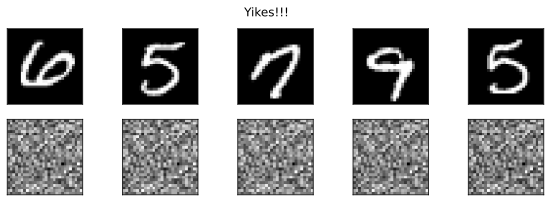

In [ ]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i, :].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i, :].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Yikes!!!')
plt.show()

# Create a function that trains the model

In [ ]:
def func2trainModel(net, criterion, optimizer, trainBatches):
    epochs = 10000
    losses = np.zeros(epochs)

    for i in range(epochs):
        for X in trainBatches:
            yPred = net(X)
            loss = criterion(yPred, X)

            losses[i] = loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return losses, net

In [ ]:
ind = np.random.randint(0, data.shape[0], size=32)

In [ ]:
ds = np.delete(data, range(500), axis=0)

In [ ]:
ds.shape

(19500, 784)

In [ ]:
def trainBatches(data, batch_size=32):
    rand_idx = np.random.permutation(data.shape[0]).astype(int)
    num_batches = data.shape[0] // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        rand_batch = data[rand_idx[start_idx: end_idx], :]

        yield rand_batch

In [ ]:
count = 0
for X in trainBatches(dataT):
    count += 1
print(count)
print(X.shape)

625
torch.Size([32, 784])


In [ ]:
encodingUnits = np.linspace(10, 500, 12, dtype=np.int32)
bottleneckUnits = np.linspace(5, 100, 8, dtype=np.int32)
numEpochs = 10000
trainLoader = trainBatches(dataT, batch_size=32)

losses_enc_by_bneck = np.zeros([len(encodingUnits), len(bottleneckUnits)])
for i, eU in enumerate(encodingUnits):
    for j, bU in enumerate(bottleneckUnits):
        net, criterion, optimizer = createTheMNISTAE(eU, bU)
        losses = func2trainModel(net, criterion, optimizer, trainLoader)[0]

        losses_enc_by_bneck[i, j] = np.mean(losses[-10:])

In [ ]:
losses_enc_by_bneck.shape

(12, 8)

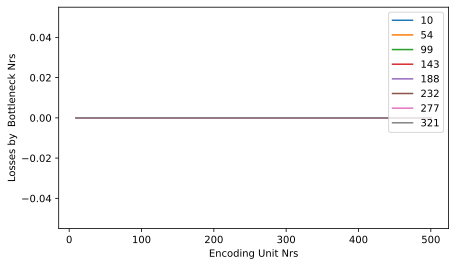

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(encodingUnits, losses_enc_by_bneck[:, :])

plt.xlabel("Encoding Unit Nrs")
plt.ylabel("Losses by  Bottleneck Nrs")
plt.legend(encodingUnits)